This script takes a route design and calculates a distance and a (arbitrary) noise metric. Next to this, there is also a way to take the route design and have it flown by an aircraft with realistic physics via BlueSky, after which the route can be analysed. At the end of this notebook there are some alternative noise evaluations listed, but for the purpose of this script it doesnt really matter as long as the increase is realistic.

In [12]:
# needed packages are loaded
import pyproj
import geopandas
import pandas as pd
import shapely
import numpy as np

In [6]:
# load the map containing the data and the CRS the maps are made in
wgs84_geod = pyproj.Geod(ellps='WGS84')
data = geopandas.read_file('..//1 - Source Data and Processing//B - Output//datamap.shp')

#define function that returns distance between two points (and bearing if wanted, but not necessary here)
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist

In [7]:
#enter starting coordinates from 2 - Extra Maps
start_coord = [[51.690536,5.890132]]
last_coord = [52.1958388,5.0733256]

#create points from coordinates
p1 = shapely.Point(start_coord[0][1], start_coord[0][0])
p2 = shapely.Point(last_coord[1], last_coord[0])

#create line between two points
line = shapely.LineString([p1,p2])

# shapely works in arbitrary distances so a meter needs to be defined based on the values it uses
shapely_meter = line.length / Distance(start_coord[0][0], start_coord[0][1], last_coord[0], last_coord[1])

#segments of 100m are used in evaluation of noise
segmentlength = shapely_meter*100

In [ ]:
# The following function returns the dataframe that needs to be evaluated for noise and distances
# It automatically scales based on the amount of segments used
# In the previous run students could add up to 5 points, leading to a maximum of 6 segments

def append_coords(start_coord, coord_1, coord_2, coord_3, coord_4, coord_5, last_coord):
    coordslist = start_coord
    if coord_1 == []:
        # coords.append(start_coord)
        coordslist.append(last_coord)
    elif coord_2 == []:
        # coords.append(start_coord)
        coordslist.append(coord_1)
        coordslist.append(last_coord)
    elif coord_3 == []:
        # coords.append(start_coord)
        coordslist.append(coord_1)
        coordslist.append(coord_2)
        coordslist.append(last_coord)
    elif coord_4 == []:
        # coords.append(start_coord)
        coordslist.append(coord_1)
        coordslist.append(coord_2)
        coordslist.append(coord_3)
        coordslist.append(last_coord)
    elif coord_5 == []:
        # coords.append(start_coord)
        coordslist.append(coord_1)
        coordslist.append(coord_2)
        coordslist.append(coord_3)
        coordslist.append(coord_4)
        coordslist.append(last_coord)
    else:
        # coords.append(start_coord)
        coordslist.append(coord_1)
        coordslist.append(coord_2)
        coordslist.append(coord_3)
        coordslist.append(coord_4)
        coordslist.append(coord_5)
        coordslist.append(last_coord)
    coords = pd.DataFrame(coordslist, columns = ['lat','lon'])
    return coords

The cells above only need to be run once, with the 3 cells below used to evaluate routes

As a workflow, students brought a map with defined points. The coordinates of these points were looked up in QGIS, and entered below in order. After a run, the commented code could be used to replace the filled lists

In [10]:
# here the points as defined by the students are entered
# the points below are included as an example

coord_1 = [51.72730,5.67241]
coord_2 = [51.97647,5.38148]
coord_3 = [52.12650,5.32865]
coord_4 = [52.18977,5.18580]
coord_5 = []

# coord_1 = []
# coord_2 = []
# coord_3 = []
# coord_4 = []
# coord_5 = []

#the coords are appended into a dataframe, which is printed to quickly see if anything went wrong
coords = append_coords(start_coord, coord_1, coord_2, coord_3, coord_4, coord_5, last_coord)
coords

,lat,lon
0,51.690536,5.890132
1,51.727300,5.672410
2,51.976470,5.381480
3,52.126500,5.328650
4,52.189770,5.185800
5,52.195839,5.073326


In [13]:
# empty list is created that will contain the points in case an export to GIS is made
points_df = []

# distance and noise are set to 0 for this run
afstand = 0
geluid = 0

# the coords dataframe above is looped through in n-1 steps, as the segments and not the individual points are needed
for j in range(len(coords)-1):
    # the start and end points of a segments are turned into shapely points
    p1 = shapely.Point(coords.lon.iloc[j],      coords.lat.iloc[j])
    p2 = shapely.Point(coords.lon.iloc[j+1],    coords.lat.iloc[j+1])
    # these points are turned into a line
    line = shapely.LineString([p1,p2])
    # the distance is calculated between these points and it is added to the total
    afstand += Distance(coords.lat.iloc[j], coords.lon.iloc[j], coords.lat.iloc[j+1], coords.lon.iloc[j+1])

    # here the line is split into segments
    distances = np.arange(0, line.length, segmentlength)
    #points are created at the ends of these segments
    points = [line.interpolate(distance) for distance in distances]
    
    # the list of points is run through
    for i in range(len(points)):
        # points are added to the list created above
        points_df.append(points[i])

        # the noise value is calculated for a circle with radius 400 and 800 meters from the point and added to the total
        geluid += data.loc[points[i].buffer(shapely_meter*1600).contains(data.geometry)].inwoners.values.sum() / len(data.loc[points[i].buffer(shapely_meter*1600).contains(data.geometry)])/2
        geluid += data.loc[points[i].buffer(shapely_meter*800).contains(data.geometry)].inwoners.values.sum() / len(data.loc[points[i].buffer(shapely_meter*800).contains(data.geometry)])/2


In [14]:
#results are printed

print("Totale afstand van de route is " + str(afstand/1000) + ' kilometer')
print("Het geluid op deze route is " + str(geluid))

Totale afstand van de route is 86.6579417947584 kilometer
Het geluid op deze route is 26895.264453119304


This concludes the main part, below is a cell that turns the defined route into a mp for QGIS that can be analyzed to find out what parts cause the most noise disturbance

In [15]:
#a dataframe is created containing the points
output = pd.DataFrame(points_df, columns=['geometry'])

#an extra column that will contain the noise is added
output['geluid'] = 0

#all points are looped through
for i in range(len(output)):
    #the sound value per point as found above is added to each entry
    output.geluid.iloc[i] = (data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)])/2) + (data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)])/2)
output

#the dataframe is turned into a geopandas dataframe and is exported
output = geopandas.GeoDataFrame(output, geometry='geometry', crs='EPSG:4326')
output.to_file('Groep_X_test_Y.shp', driver='ESRI Shapefile')

C:\Users\posts\AppData\Local\Temp\ipykernel_25244\4236046792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output.inwoners.iloc[i] = (data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)])/2) + (data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)])/2)


The following cells contain a method to evaluate a route based on how it would actually be flown, compared to the straight lines used above. This can be done via the BlueSky Traffic Simulator, which can be found at https://github.com/TUDelft-CNS-ATM/bluesky

An example scenario file for BlueSky is contained in the folder as well.

In the end this part wasnt used in the actual workshop, as the path differences between this and the straight line approach were negligible.

In [35]:
# a log file from bluesky is loaded
flown_route = pd.read_csv("AAA - BLUESKYlog.log", skiprows=1)

#column labels are added for indexing
flown_route.columns = ["simt", "lat", "lon"]
flown_route


,simt,lat,lon
0,2.0,51.690536,5.890132
1,2.5,51.690756,5.888820
2,3.0,51.690975,5.887508
3,3.5,51.691195,5.886196
4,4.0,51.691415,5.884884
...,...,...,...
910,457.0,52.197780,5.063678
911,457.5,52.198043,5.062372
912,458.0,52.198306,5.061066
913,458.5,52.198568,5.059760


In [36]:
# empty list is created that will contain the points in case an export to GIS is made
points_df = []

# distance and noise are set to 0 for this run
afstand = 0
geluid = 0


# the flown route dataframe above is looped through in n-1 steps, these not being the segments as seen above but the logged positions
for j in range(len(flown_route)-1):
    # the start and end points of a segments are turned into shapely points
    p1 = shapely.Point(flown_route.lon.iloc[j],      flown_route.lat.iloc[j])
    p2 = shapely.Point(flown_route.lon.iloc[j+1],    flown_route.lat.iloc[j+1])
    # these points are turned into a line
    line = shapely.LineString([p1,p2])
    # the distance is calculated between these points and it is added to the total
    afstand += Distance(flown_route.lat.iloc[j], flown_route.lon.iloc[j], flown_route.lat.iloc[j+1], flown_route.lon.iloc[j+1])
    
    # points are added to the list created above
    points_df.append(p1)
    # the noise value is calculated for a circle with radius 400 and 800 meters from the point and added to the total
    geluid += data.loc[p1.buffer(shapely_meter*1600).contains(data.geometry)].inwoners.values.sum() / len(data.loc[p1.buffer(shapely_meter*1600).contains(data.geometry)])/2
    geluid += data.loc[p1.buffer(shapely_meter*800).contains(data.geometry)].inwoners.values.sum() / len(data.loc[p1.buffer(shapely_meter*800).contains(data.geometry)])/2

 

In [37]:
#results are printed

print("Totale afstand van de route is " + str(afstand/1000) + ' kilometer')
print("Het geluid op deze route is " + str(geluid))

Totale afstand van de route is 85.77735630157518 kilometer
Het geluid op deze route is 38883.17621635607


In [38]:
#a dataframe is created containing the points
output = pd.DataFrame(points_df, columns=['geometry'])

#an extra column that will contain the noise is added
output['geluid'] = 0

#all points are looped through
for i in range(len(output)):
    #the sound value per point as found above is added to each entry
    output.geluid.iloc[i] = (data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)])/2) + (data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)])/2)
output

#the dataframe is turned into a geopandas dataframe and is exported
output = geopandas.GeoDataFrame(output, geometry='geometry', crs='EPSG:4326')
output.to_file('Groep_X_test_Y_flown.shp', driver='ESRI Shapefile')

C:\Users\posts\AppData\Local\Temp\ipykernel_12152\2182384513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output.inwoners.iloc[i] = (data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*1600).contains(data.geometry)])/2) + (data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)].inwoners.values.sum() / len(data.loc[output.geometry.iloc[i].buffer(shapely_meter*800).contains(data.geometry)])/2)


Below are some more options for evaluating sound at a point

<AxesSubplot: >

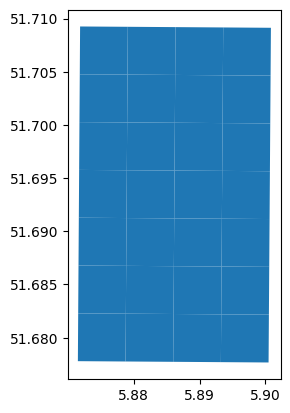

In [196]:
i = 4
bonus = 1000

coords1 = points[i].x + (shapely_meter*bonus), points[i].y + (shapely_meter*bonus)
coords2 = points[i].x - (shapely_meter*bonus), points[i].y + (shapely_meter*bonus)
coords3 = points[i].x - (shapely_meter*bonus), points[i].y - (shapely_meter*bonus)
coords4 = points[i].x + (shapely_meter*bonus), points[i].y - (shapely_meter*bonus)
coords5 = points[i].x + (shapely_meter*bonus), points[i].y + (shapely_meter*bonus)

p6 = shapely.Polygon([coords1,coords2,coords3,coords4,coords5])
data.loc[p6.intersects(data.geometry)].geometry.plot()

<AxesSubplot: >

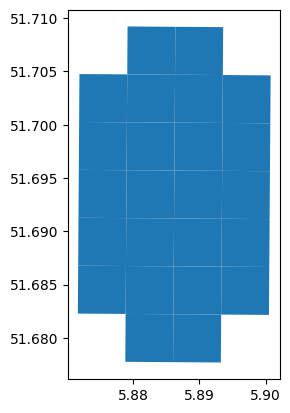

In [198]:
p7 =  points[i].buffer(shapely_meter*1600)
data.loc[p7.contains(data.geometry)].geometry.plot()

In [155]:
p5 = points[0]
data.loc[p5.buffer(shapely_meter*1000).contains(data.geometry)].inwoners.values.sum()

15

As can be seen below the methods don't differ too much

In [201]:
totaal1 = 0
totaal2 = 0
totaal3 = 0

for i in range(len(points)):
    totaal1 += data.loc[points[i].within(data.geometry)].inwoners.values[0]
    totaal2 += data.loc[points[i].buffer(shapely_meter*1600).contains(data.geometry)].inwoners.values.sum() / len(data.loc[points[i].buffer(shapely_meter*1600).contains(data.geometry)])/2
    totaal2 += data.loc[points[i].buffer(shapely_meter*800).contains(data.geometry)].inwoners.values.sum() / len(data.loc[points[i].buffer(shapely_meter*800).contains(data.geometry)])/2

    coords1 = points[i].x + (shapely_meter*500), points[i].y + (shapely_meter*500)
    coords2 = points[i].x - (shapely_meter*500), points[i].y + (shapely_meter*500)
    coords3 = points[i].x - (shapely_meter*500), points[i].y - (shapely_meter*500)
    coords4 = points[i].x + (shapely_meter*500), points[i].y - (shapely_meter*500)
    coords5 = points[i].x + (shapely_meter*500), points[i].y + (shapely_meter*500)

    p6 = shapely.Polygon([coords1,coords2,coords3,coords4,coords5])
    

    totaal3 += data.loc[p6.overlaps(data.geometry)].inwoners.values.sum() / len(data.loc[p6.overlaps(data.geometry)])


totaal1, totaal2, totaal3

(121730, 125435.51665725569, 127096.1031746032)